# Thermal models

There are a number of thermal submodels available in PyBaMM. In this notebook we give details of each of the models, and highlight any relevant parameters. At present PyBaMM includes an isothermal and a lumped thermal model, both of which can be used with any cell geometry, as well as a 1D thermal model which accounts for the through-cell variation in temperature in a pouch cell, and "1+1D" and "2+1D" pouch cell models which assumed the temperature is uniform through the thickness of the pouch, but accounts for variations in temperature in the remaining dimensions. Here we give the governing equations for each model (except the isothermal model, which just sets the temperature to be equal to to the parameter "Ambient temperature [K]"). 

A more comprehensive review of the pouch cell models, including how to properly compute the effective cooling terms, can be found in references [4] and [6] at the end of this notebook.

In [1]:
#%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm

## Lumped model

The lumped thermal model solves the following ordinary differential equation for the average temperature, given here in dimensional terms,

$$
\rho_{eff} \frac{\partial T}{\partial t} = \bar{Q} - \frac{hA}{V}(T-T_{\infty}),
$$

where $\rho_{eff}$ is effective volumetric heat capacity, $T$ is the temperature, $t$ is time, $\bar{Q}$ is the averaged heat source term, $h$ is the heat transfer coefficient, $A$ is the surface area (available for cooling), $V$ is the cell volume, and $T_{\infty}$ is the ambient temperature. An initial temperature $T_0$ must be prescribed.


The effective volumetric heat capacity is computed as 

$$
\rho_{eff} = \frac{\sum_k \rho_k c_{p,k} L_k}{\sum_k L_k},
$$

where $\rho_k$ is the density, $c_{p,k}$ is the specific heat, and $L_k$ is the thickness of each component. The subscript $k \in \{cn, n, s, p, cp\}$ is used to refer to the components negative current collector, negative electrode, separator, positive electrode, and positive current collector.

The heat source term accounts for Ohmic heating $Q_{Ohm,k}$ due to resistance in the solid and electrolyte, irreverisble heating due to electrochemical reactions $Q_{rxn,k}$, reversible heating due to entropic changes in the the electrode $Q_{rev,k}$, and heating due to contact resistance $Q_{cr}$:

$$
Q = Q_{Ohm,k}+Q_{rxn,k}+Q_{rev,k}+Q_{cr},
$$

with

$$ 
Q_{Ohm,k} = -i_k \nabla \phi_k, \quad Q_{rxn,k} = a_k j_k \eta_k, \quad Q_{rev,k} = a_k j_k T_k \frac{\partial U}{\partial T} \bigg|_{T=T_{\infty}}, Q_{cr} = \frac{R_{cr}}{V_{cell}}i_k^2.
$$

Here $i_k$ is the current, $\phi_k$ the potential, $a_k$ the surface area to volume ratio, $j_k$ the interfacial current density, $\eta_k$ the overpotential, $U$ the open-circuit potential, $R_{cr}$ is the contact resistance, and $V_{cell}$ is the total cell volume. The averaged heat source term $\bar{Q}$ is computed by taking the volume-average of $Q$.




When using the option `{"cell geometry": "arbitrary"}` the relevant parameters to specify the cooling conditions are:  

"Total heat transfer coefficient [W.m-2.K-1]"  
"Cell cooling surface area [m2]"  
"Cell volume [m3]"

which correspond directly to the parameters $h$, $A$ and $V$ in the governing equation.

When using the option `{"cell geometry": "pouch"}` the parameter $A$ and $V$ are computed automatically from the pouch dimensions, assuming a single-layer pouch cell, i.e. $A$ is the total surface area of a single-layer pouch cell and $V$ is the volume. The parameter $h$ is still set by the "Total heat transfer coefficient [W.m-2.K-1]" parameter.

When using the option `{"contact resistance": "true"}` the parameter "Contact resistance [Ohm]" must be specified to calculate the heating from contact resistance, which corresponds to $R_{cr}$. "Cell volume [m3]" is $V_{cell}$ within the governing equation. The default lumped model option is `{"contact resistance": "false"}`.

The lumped thermal option can be selected as follows


In [2]:
options = {"cell geometry": "arbitrary", "thermal": "lumped"}
arbitrary_lumped_model = pybamm.lithium_ion.DFN(options)
# OR
options = {"cell geometry": "pouch", "thermal": "lumped"}
pouch_lumped_model = pybamm.lithium_ion.DFN(options)

If no cell geometry is specified, the "arbitrary" cell geometry is used by default

In [3]:
options = {"thermal": "lumped"}
model = pybamm.lithium_ion.DFN(options)
print("Cell geometry:", model.options["cell geometry"])

Cell geometry: arbitrary


The contact resistance option can be turned on via the following

In [4]:
options = {"thermal": "lumped", "contact resistance": "true"}
model = pybamm.lithium_ion.DFN(options)

The default option for the lumped model does not include contact resistance.

In [5]:
options = {"thermal": "lumped"}
model = pybamm.lithium_ion.DFN(options)
print("contact resistance:", model.options["contact resistance"])

contact resistance: false


## Pouch cell models

### 1D (through-cell) model

The 1D model solves for $T(x,t)$, capturing variations through the thickness of the cell, but ignoring variations in the other dimensions. The temperature is found as the solution of a partial differential equation, given here in dimensional terms

$$\rho_k c_{p,k} \frac{\partial T}{\partial t} = \lambda_k \nabla^2 T + Q(x,t) - Q_{cool}(x,t)$$

with boundary conditions 

$$ -\lambda_{cn} \frac{\partial T}{\partial x}\bigg|_{x=0} = h_{cn}(T_{\infty} - T) \quad -\lambda_{cp} \frac{\partial T}{\partial x}\bigg|_{x=1} = h_{cp}(T-T_{\infty}),$$

and initial condition

$$ T\big|_{t=0} = T_0.$$

Here $\lambda_k$ is the thermal conductivity of component $k$, and the heat transfer coefficients $h_{cn}$ and $h_{cp}$ correspond to heat transfer at the large surface of the pouch on the side of the negative current collector, heat transfer at the large surface of the pouch on the side of the positive current collector, respectively. The heat source term $Q$ is as described in the section on lumped models. The term $Q_cool$ accounts for additional heat losses due to heat transfer at the sides of the pouch, as well as the tabs. This term is computed automatically by PyBaMM based on the cell geometry and heat transfer coefficients on the edges and tabs of the cell.

The relevant heat transfer parameters are:
"Negative current collector surface heat transfer coefficient [W.m-2.K-1]"
"Positive current collector surface heat transfer coefficient [W.m-2.K-1]"
"Negative tab heat transfer coefficient [W.m-2.K-1]"
"Positive tab heat transfer coefficient [W.m-2.K-1]"
"Edge heat transfer coefficient [W.m-2.K-1]"

The 1D model is termed "x-full" (since it fully accounts for variation in the x direction) and can be selected as follows


In [6]:
options = {"thermal": "x-full"}
model = pybamm.lithium_ion.DFN(options)

## Higher dimensional pouch cell models

These pouch cell thermal models ignore any variation in temperature through the thickness of the cell (x direction), and solve for $T(y,z,t)$. It is therefore referred to as an "x-lumped" model. The temperature is found as the solution of a partial differential equation, given here in dimensional terms,

$$
\rho_{eff} \frac{\partial T}{\partial t} = \lambda_{eff} \nabla_\perp^2T + \bar{Q} - \frac{(h_{cn}+h_{cp})A}{V}(T-T_{\infty}),
$$

along with boundary conditions

$$
-\lambda_{eff} \nabla_\perp T \cdot \boldsymbol{n} = \frac{L_{cn}h_{cn} + (L_n+L_s+L_p+L_{cp})h_{edge}}{L_{cn}+L_n+L_s+L_p+L_{cp}}(T-T_\infty),
$$

at the negative tab,

$$
-\lambda_{eff} \nabla_\perp T \cdot \boldsymbol{n} = \frac{(L_{cn}+L_n+L_s+L_p)h_{edge}+L_{cp}h_{cp}}{L_{cn}+L_n+L_s+L_p+L_{cp}}(T-T_\infty),
$$

at the positive tab, and

$$
-\lambda_{eff} \nabla_\perp T \cdot \boldsymbol{n} = h_{edge}(T-T_\infty),
$$

elsewhere. Again, an initial temperature $T_0$ must be prescribed.

Here the heat source term is averaged in the x direction so that $\bar{Q}=\bar{Q}(y,z)$. The parameter $\lambda_{eff}$ is the effective thermal conductivity, computed as 

$$
\lambda_{eff} = \frac{\sum_k \lambda_k L_k}{\sum_k L_k}.
$$

The heat transfer coefficients $h_{cn}$, $h_{cp}$ and $h_{egde}$ correspond to heat transfer at the large surface of the pouch on the side of the negative current collector, heat transfer at the large surface of the pouch on the side of the positive current collector, and  heat transfer at the remaining, respectively.

The relevant heat transfer parameters are:
"Negative current collector surface heat transfer coefficient [W.m-2.K-1]"
"Positive current collector surface heat transfer coefficient [W.m-2.K-1]"
"Negative tab heat transfer coefficient [W.m-2.K-1]"
"Positive tab heat transfer coefficient [W.m-2.K-1]"
"Edge heat transfer coefficient [W.m-2.K-1]"

The "2+1D" model can be selected as follows

In [7]:
options = {
    "current collector": "potential pair",
    "dimensionality": 2,
    "thermal": "x-lumped",
}
model = pybamm.lithium_ion.DFN(options)

# Model usage

Here we compare the "full" one-dimensional model with the lumped model for a pouch cell. We first set up our models, passing the relevant options, and then show how to adjust the parameters to so that the lumped and full models give the same behaviour

In [8]:
full_thermal_model = pybamm.lithium_ion.SPMe(
    {"thermal": "x-full"}, name="full thermal model"
)
lumped_thermal_model = pybamm.lithium_ion.SPMe(
    {"thermal": "lumped"}, name="lumped thermal model"
)
models = [full_thermal_model, lumped_thermal_model]

We then pick our parameter set

In [9]:
parameter_values = pybamm.ParameterValues("Marquis2019")

For the "full" model we use a heat transfer coefficient of $5\,  \text{Wm}^{-2}\text{K}^{-1}$ on the large surfaces of the pouch and zero heat transfer coefficient on the tabs and edges

In [10]:
full_params = parameter_values.copy()
full_params.update(
    {
        "Negative current collector"
        + " surface heat transfer coefficient [W.m-2.K-1]": 5,
        "Positive current collector"
        + " surface heat transfer coefficient [W.m-2.K-1]": 5,
        "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
        "Edge heat transfer coefficient [W.m-2.K-1]": 0,
    }
)

For the lumped model we set the "Total heat transfer coefficient [W.m-2.K-1]"
parameter as well as the "Cell cooling surface area [m2]" parameter. Since the "full"
model only accounts for cooling from the large surfaces of the pouch, we set the
"Surface area for cooling" parameter to the area of the large surfaces of the pouch,
and the total heat transfer coefficient to $5\,  \text{Wm}^{-2}\text{K}^{-1}$ 

In [11]:
A = parameter_values["Electrode width [m]"] * parameter_values["Electrode height [m]"]
lumped_params = parameter_values.copy()
lumped_params.update(
    {
        "Total heat transfer coefficient [W.m-2.K-1]": 5,
        "Cell cooling surface area [m2]": 2 * A,
    }
)

Let's run simulations with both options and compare the results. For demonstration purposes we'll increase the current to amplify the thermal effects

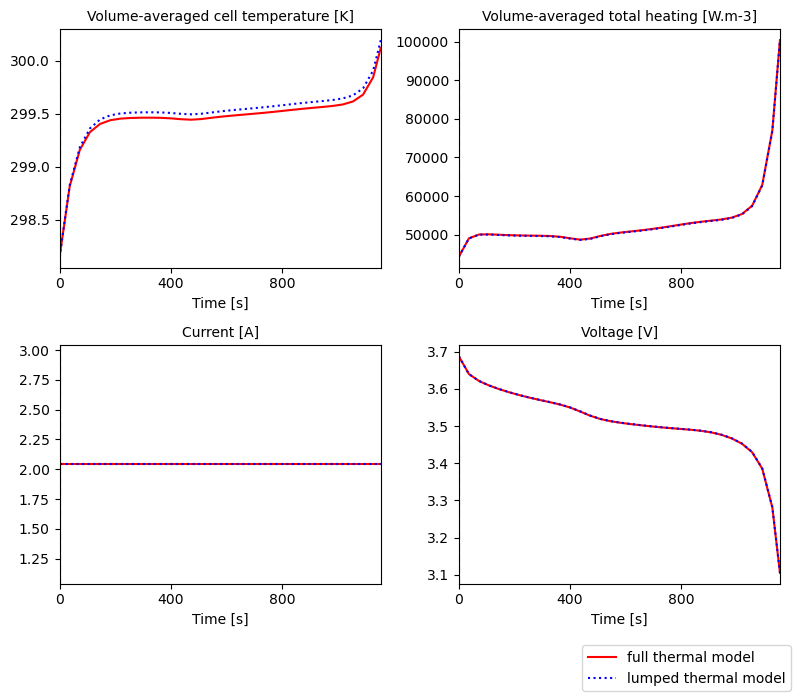

interactive(children=(FloatSlider(value=0.0, description='t', max=1154.7927025499785, step=11.547927025499785)…

In [12]:
params = [full_params, lumped_params]
# loop over the models and solve
sols = []
for model, param in zip(models, params):
    param["Current function [A]"] = 3 * 0.68
    sim = pybamm.Simulation(model, parameter_values=param)
    sim.solve([0, 3600])
    sols.append(sim.solution)


# plot
output_variables = [
    "Voltage [V]",
    "X-averaged cell temperature [K]",
    "Cell temperature [K]",
]
pybamm.dynamic_plot(sols, output_variables)

# plot the results
pybamm.dynamic_plot(
    sols,
    [
        "Volume-averaged cell temperature [K]",
        "Volume-averaged total heating [W.m-3]",
        "Current [A]",
        "Voltage [V]",
    ],
)

For the lumped model, we can compare how the contact resistance affects the heating. To do so, we must set the `"contact resistance"` option to `"true"` and update the `"Contact resistance [Ohm]"` parameter.

In [13]:
model_no_contact_resistance = pybamm.lithium_ion.SPMe(
    {"cell geometry": "arbitrary", "thermal": "lumped", "contact resistance": "false"},
    name="lumped thermal model",
)
model_contact_resistance = pybamm.lithium_ion.SPMe(
    {"cell geometry": "arbitrary", "thermal": "lumped", "contact resistance": "true"},
    name="lumped thermal model with contact resistance",
)
models = [model_no_contact_resistance, model_contact_resistance]

We then choose a parameter set.

In [14]:
parameter_values = pybamm.ParameterValues("Marquis2019")
lumped_params = parameter_values.copy()
lumped_params_contact_resistance = parameter_values.copy()

For the contact resistance model, we must specify a contact resistance greater than zero. The default is zero.

In [15]:
lumped_params_contact_resistance.update(
    {
        "Contact resistance [Ohm]": 0.05,
    }
)

The models and parameters are then used to solve for a 1C discharge.

In [16]:
params = [lumped_params, lumped_params_contact_resistance]
sols = []
for model, param in zip(models, params):
    sim = pybamm.Simulation(model, parameter_values=param)
    sim.solve([0, 3600])
    sols.append(sim.solution)

We can then compare the voltage and cell temperature and see the impact of the contact resistance.

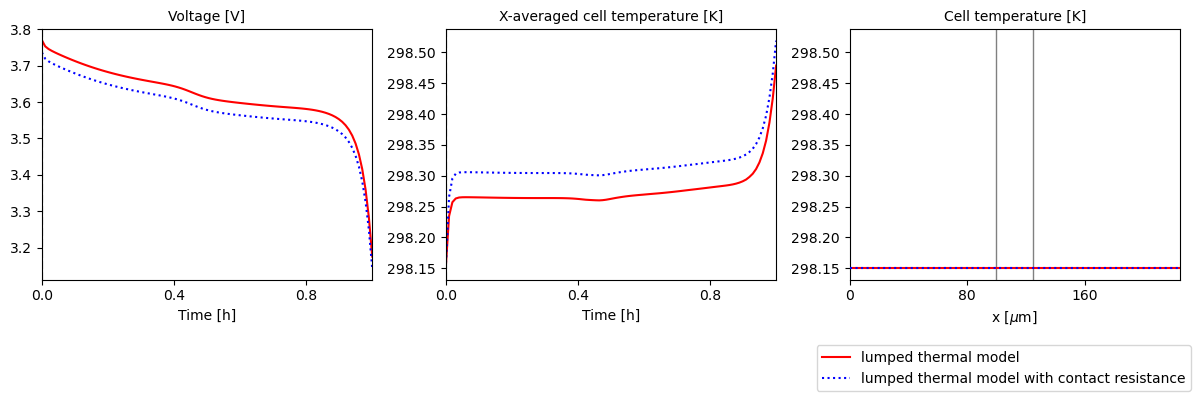

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [17]:
output_variables = [
    "Voltage [V]",
    "X-averaged cell temperature [K]",
    "Cell temperature [K]",
]
pybamm.dynamic_plot(sols, output_variables)

## References

The relevant papers for this notebook are:

In [18]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[5] 